# 3. Machine Learning for Classification

We'll use logistic regression to predict churn

### 3.2 Data preparation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/telco_customer_churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')


In [5]:
# review all columns
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [6]:
# some charges are missing, replace with zero
tc_num = pd.to_numeric(df.totalcharges, errors='coerce')
df[tc_num.isnull()][['customerid', 'totalcharges']]


,customerid,totalcharges
488,4472-lvygi,_
753,3115-czmzd,_
936,5709-lvoeq,_
1082,4367-nuyao,_
1340,1371-dwpaz,_
3331,7644-omvmy,_
3826,3213-vvolg,_
4380,2520-sgtta,_
5218,2923-arzlg,_
6670,4075-wkniu,_


In [7]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0) 

In [8]:
# convert 'yes' to 1
df.churn = (df['churn'] == "yes").astype(int)

### 3.3 Setting up the validation framework

Perform the train/validation/test split with Scikit-Learn

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# review documentation
train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [12]:
len(df_full_train), len(df_test)

(5634, 1409)

In [13]:
# adjust proportion test size to be 20% of total, after reduction by 20%
df_train, df_val = train_test_split(df_full_train, test_size=0.2/0.8, random_state=1)

In [14]:
len(df_train), len(df_val)

(4225, 1409)

In [15]:
1409/len(df)

0.20005679397983814

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_full_train = df_full_train.reset_index(drop=True)

In [17]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

### EDA

In [18]:
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [19]:
# Churn rate, proportion churn
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [20]:
df_full_train.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

In [21]:
numerical_columns = ['tenure', 'monthlycharges', 'totalcharges']

In [22]:
categorical_columns = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [23]:
df_full_train[categorical_columns].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### 3.5 Feature importance: Churn rate and risk ratio

#### Female churn rate

In [24]:
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
churn_female


np.float64(0.27682403433476394)

#### Male churn rate

In [25]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_male

np.float64(0.2632135306553911)

In [26]:
global_churn = df_full_train[df_full_train.gender == 'male'].churn.mean()
global_churn

np.float64(0.2632135306553911)

#### Partner churn rate

In [27]:
df_full_train.partner.value_counts()

partner
no     2932
yes    2702
Name: count, dtype: int64

In [28]:
partner_yes = df_full_train[df_full_train.partner == 'yes'].churn.mean()
partner_no = df_full_train[df_full_train.partner == 'no'].churn.mean()

partner_yes, partner_no

(np.float64(0.20503330866025166), np.float64(0.3298090040927694))

In [29]:
# absolute difference to mean
global_churn-partner_yes, global_churn-partner_no

(np.float64(0.05818022199513945), np.float64(-0.06659547343737832))

### Risk Ratio

Risk = group / global

In [30]:
partner_yes / global_churn, partner_no / global_churn

(np.float64(0.7789618875204742), np.float64(1.2530093087219272))

In [31]:
c = 'partner'
# Use method `agg` to return data.frame, instead of a series using `mean()`
df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
df_group['diff'] = df_group['mean'] - global_churn
df_group['risk'] = df_group['mean'] / global_churn
df_group

,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.066595,1.253009
yes,0.205033,2702,-0.058180,0.778962


In [32]:
from IPython.display import display

In [33]:
for c in categorical_columns:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.013611,1.051709
male,0.263214,2838,0.000000,1.000000


seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.020943,0.920432
1,0.413377,912,0.150164,1.570501


partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.066595,1.253009
yes,0.205033,2702,-0.058180,0.778962


dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.050547,1.192036
yes,0.165666,1666,-0.097547,0.629399


phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.021897,0.916808
yes,0.273049,5087,0.009835,1.037367


multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.005806,0.977941
no_phone_service,0.241316,547,-0.021897,0.916808
yes,0.290742,2387,0.027528,1.104584


internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.070866,0.730766
fiber_optic,0.425171,2479,0.161958,1.615310
no,0.077805,1221,-0.185408,0.295597


onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.157708,1.599162
no_internet_service,0.077805,1221,-0.185408,0.295597
yes,0.153226,1612,-0.109988,0.582135


onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.141110,1.536104
no_internet_service,0.077805,1221,-0.185408,0.295597
yes,0.217232,1915,-0.045981,0.825309


deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.132662,1.504009
no_internet_service,0.077805,1221,-0.185408,0.295597
yes,0.230412,1940,-0.032801,0.875382


techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.155701,1.591537
no_internet_service,0.077805,1221,-0.185408,0.295597
yes,0.159926,1632,-0.103287,0.607592


streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.079618,1.302485
no_internet_service,0.077805,1221,-0.185408,0.295597
yes,0.302723,2167,0.039509,1.150103


streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.075693,1.287572
no_internet_service,0.077805,1221,-0.185408,0.295597
yes,0.307273,2200,0.044059,1.167390


contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.168488,1.640117
one_year,0.120573,1186,-0.142640,0.458082
two_year,0.028274,1344,-0.234940,0.107418


paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.091143,0.653731
yes,0.338151,3321,0.074938,1.284703


paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.095043,0.638913
credit_card_(automatic),0.164339,1217,-0.098875,0.624354
electronic_check,0.455890,1893,0.192677,1.732016
mailed_check,0.193870,1305,-0.069344,0.736549



### 3.6 Feature importance: Mutual information

Mutual information - concept from information theory, it tells us how much we can learn about one variable if we know the value of another

    https://en.wikipedia.org/wiki/Mutual_information



In [34]:
from sklearn.metrics import mutual_info_score

In [35]:
mutual_info_score?

Signature: mutual_info_score(labels_true, labels_pred, *, contingency=None)
Docstring:
Mutual Information between two clusterings.

The Mutual Information is a measure of the similarity between two labels
of the same data. Where :math:`|U_i|` is the number of the samples
in cluster :math:`U_i` and :math:`|V_j|` is the number of the
samples in cluster :math:`V_j`, the Mutual Information
between clusterings :math:`U` and :math:`V` is given as:

.. math::

    MI(U,V)=\sum_{i=1}^{|U|} \sum_{j=1}^{|V|} \frac{|U_i\cap V_j|}{N}
    \log\frac{N|U_i \cap V_j|}{|U_i||V_j|}

This metric is independent of the absolute values of the labels:
a permutation of the class or cluster label values won't change the
score value in any way.

This metric is furthermore symmetric: switching :math:`U` (i.e
``label_true``) with :math:`V` (i.e. ``label_pred``) will return the
same score value. This can be useful to measure the agreement of two
independent label assignments strategies on the same dataset when the

In [36]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

0.0983203874041556

In [37]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [38]:
mi = df_full_train[categorical_columns].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64


### 3.7 Feature importance: Correlation
  
How about numerical columns?  
  
Correlation coefficient - https://en.wikipedia.org/wiki/Pearson_correlation_coefficient


In [39]:
df_full_train[numerical_columns].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [40]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

np.float64(0.5953420669577875)

In [41]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean()

np.float64(0.3994413407821229)

In [42]:
df_full_train[df_full_train.tenure > 12].churn.mean()

np.float64(0.17634908339788277)


### 3.8 One-hot encoding  
  
Use Scikit-Learn to encode categorical features  

In [43]:
from sklearn.feature_extraction import DictVectorizer

In [44]:
# turn each record into a dictionary
my_dict = df_train[['gender', 'contract']].iloc[:10].to_dict(orient='records')

In [45]:
my_dict[0]

{'gender': 'female', 'contract': 'two_year'}

In [46]:
# instantiate class vectorizer
dv = DictVectorizer(sparse=False)
dv.fit_transform(my_dict)

array([[0., 1., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [1., 0., 1., 0.]])

In [47]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=two_year', 'gender=female',
       'gender=male'], dtype=object)

In [48]:
# instantiate class vectorizer
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
# validation uses the one-hot-encoding fit from training
X_val = dv.transform(val_dict)

### 3.9 Logistic regression  
  
* Binary classification  
* Linear vs logistic regression  
* Train a model with Scikit-Learn
* Apply it to the validation dataset
* Calculate the accuracy


In [49]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

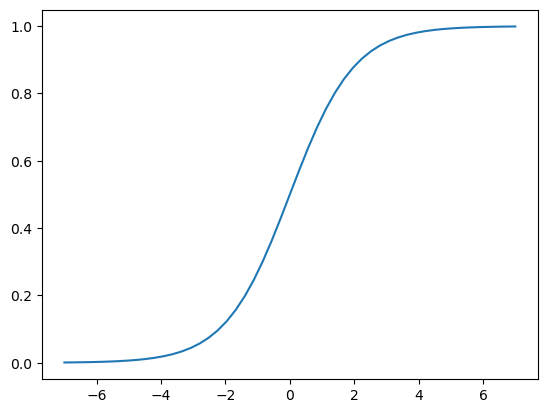

In [50]:
z = np.linspace(-7, 7, 51)
sigmoid(10000)
plt.plot(z, sigmoid(z))

In [51]:
def logistic_regression(xi):
    score = w0
    
    for j in range(len(w)):
        score = score + xi[j] * w[j]
        
    result = sigmoid(score)
    return result



In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
# solver='lbfgs' is the default solver in newer version of sklearn
model = LogisticRegression(solver='lbfgs')

model.fit(X_train, y_train)

/home/oogi-poh-poh/miniconda3/envs/datascience/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [54]:
model.intercept_[0].round(3)

np.float64(-0.111)

In [55]:
model.coef_[0].round(3)

array([ 0.564, -0.154, -0.519, -0.013, -0.095,  0.071, -0.098, -0.082,
       -0.033, -0.076, -0.354,  0.343, -0.098,  0.002, -0.251,  0.162,
       -0.02 ,  0.066, -0.098, -0.076,  0.251, -0.098, -0.261, -0.228,
        0.119, -0.121,  0.012, -0.095, -0.03 ,  0.045, -0.028,  0.162,
       -0.271,  0.221, -0.097, -0.098,  0.087, -0.05 , -0.098,  0.039,
        0.194, -0.098, -0.205, -0.072,  0.   ])

In [56]:
# probility of churn is second column, drop prediction for no churn
y_pred = model.predict_proba(X_val)[:,1]
y_pred

array([0.00786347, 0.20992803, 0.2237105 , ..., 0.15014869, 0.77668113,
       0.81035774], shape=(1409,))

In [57]:
churn_decision = (y_pred >= 0.5)
churn_decision

array([False, False, False, ..., False,  True,  True], shape=(1409,))

### Accuracy of prediction

In [58]:
# proportion of records correctly identified to churn
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

In [59]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred.head()

,probability,prediction,actual,correct
0,0.007863,0,0,True
1,0.209928,0,0,True
2,0.223710,0,0,True
3,0.561123,1,1,True
4,0.219586,0,0,True


### 3.11 Model interpretation
  
* Look at the coefficients  
* Train a smaller model with fewer features  

In [76]:
a = [1, 2, 3, 4]
b = 'abcd'
c = 'efgh'

In [64]:
list(zip(a, b))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]

In [ ]:
dict(zip(a, zip(b, c)))

{1: ('a', 'e'), 2: ('b', 'f'), 3: ('c', 'g'), 4: ('d', 'h')}

In [79]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': np.float64(0.564),
 'contract=one_year': np.float64(-0.154),
 'contract=two_year': np.float64(-0.519),
 'dependents=no': np.float64(-0.013),
 'dependents=yes': np.float64(-0.095),
 'deviceprotection=no': np.float64(0.071),
 'deviceprotection=no_internet_service': np.float64(-0.098),
 'deviceprotection=yes': np.float64(-0.082),
 'gender=female': np.float64(-0.033),
 'gender=male': np.float64(-0.076),
 'internetservice=dsl': np.float64(-0.354),
 'internetservice=fiber_optic': np.float64(0.343),
 'internetservice=no': np.float64(-0.098),
 'monthlycharges': np.float64(0.002),
 'multiplelines=no': np.float64(-0.251),
 'multiplelines=no_phone_service': np.float64(0.162),
 'multiplelines=yes': np.float64(-0.02),
 'onlinebackup=no': np.float64(0.066),
 'onlinebackup=no_internet_service': np.float64(-0.098),
 'onlinebackup=yes': np.float64(-0.076),
 'onlinesecurity=no': np.float64(0.251),
 'onlinesecurity=no_internet_service': np.float64(-0.098),
 'onlinesecurity=yes

In [ ]:
# train a smaller model
small = ['contract', 'tenure', 'monthlycharges']

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [ ]:
# feature matrix
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)
dv_small.get_feature_names_out()



array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [83]:
X_train_small = dv_small.transform(dicts_train_small)

In [ ]:
# fit regression model
model_small = LogisticRegression(solver='lbfgs')
model_small.fit(X_train_small, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [87]:
w0 = model_small.intercept_[0]
w0.round(3)

np.float64(-2.478)

In [ ]:
w = model_small.coef_[0]
w.round(3)


array([ 0.971, -0.024, -0.948,  0.027, -0.036])

In [89]:
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': np.float64(0.971),
 'contract=one_year': np.float64(-0.024),
 'contract=two_year': np.float64(-0.948),
 'monthlycharges': np.float64(0.027),
 'tenure': np.float64(-0.036)}

### 3.12 Using the model

In [90]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]



In [91]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')

In [102]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

y_full_train = df_full_train.churn.values


In [103]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_full_train, y_full_train)

/home/oogi-poh-poh/miniconda3/envs/datascience/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [104]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(dicts_test)

y_pred = model.predict_proba(X_test)[:, 1]

In [106]:
churn_decision = (y_pred >= 0.5)
(churn_decision == y_test).mean()

np.float64(0.8140525195173882)

### Predict if a customer will churn

In [118]:
customer_i = -1

customer = dicts_test[customer_i]
customer

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [119]:
X_small = dv.transform([customer])
model.predict_proba(X_small)[0, 1]

np.float64(0.6613470087309817)

In [120]:
y_test[customer_i]

np.int64(1)